# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-09-25 05:26:31,524 INFO    : root         : Using LISA logging configuration:
2020-09-25 05:26:31,525 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-09-25 05:26:31,784 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-09-25 05:26:31,798 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMTRJR1pVUC9hcXVlZHVjdHMnLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMjAwJScpLCBzdHlsZT1EZXPigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [16]:
group1.run()
group2.run()

Parsing GIGEUSG2_POS_190701_190701_144926_gallery.html - 153560 lines are Ok
Parsing GIGEUSG2_POS_190701_190701_154437_gallery.html - 155031 lines are Ok
Parsing GIGEUSG2_POS_190701_190701_135024_gallery.html - 144883 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_222304_gallery.html - 149632 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_211640_gallery.html - 149044 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_232929_gallery.html - 169323 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [17]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1569.0,NaN,1.805,0.014,NaN,NaN,NaN,NaN,NaN
9634.0,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.52
1796.0,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8359.0,NaN,6.322,NaN,NaN,NaN,NaN,NaN,NaN
9929.0,NaN,NaN,NaN,41.613,NaN,5.931,NaN,NaN
1570.0,NaN,0.585,0.630,NaN,NaN,NaN,NaN,NaN
3633.0,1.892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2386.0,0.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1793.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1570.0,NaN,1.101,0.027,NaN,NaN,NaN,NaN,NaN
1851.0,NaN,0.096,0.064,NaN,NaN,NaN,NaN,NaN
8454.0,0.580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3142.0,NaN,0.263,7.580,NaN,NaN,NaN,NaN,NaN
2305.0,0.127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9913.0,NaN,NaN,NaN,174.491,NaN,6.198,NaN,NaN
9895.0,NaN,NaN,NaN,37.059,NaN,6.053,NaN,NaN
1265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.693


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1568.0,NaN,0.624,1.012,NaN,NaN,NaN,NaN,NaN
1803.0,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8420.0,0.443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9542.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9809.0,NaN,NaN,NaN,51.145,NaN,5.998,NaN,NaN
1256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.495
3627.0,0.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3119.0,NaN,2.623,0.620,NaN,NaN,NaN,NaN,NaN
9800.0,11.084,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12632.0,NaN,NaN,NaN,38.438,NaN,5.818,NaN,NaN
1541.0,NaN,11.574,6.131,NaN,NaN,NaN,NaN,NaN
2566.0,NaN,1.374,0.054,NaN,NaN,NaN,NaN,NaN
12721.0,NaN,NaN,NaN,191.490,NaN,13.269,NaN,NaN
4553.0,NaN,4.721,NaN,NaN,NaN,NaN,NaN,NaN
2058.0,NaN,0.063,0.057,NaN,NaN,NaN,NaN,NaN
2765.0,0.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10798.0,NaN,6.558,NaN,NaN,NaN,NaN,NaN,NaN
4751.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12682.0,NaN,NaN,NaN,225.731,NaN,11.164,NaN,NaN
10788.0,NaN,8.398,NaN,NaN,NaN,NaN,NaN,NaN
5734.0,NaN,42.898,31.092,NaN,73.525,NaN,10.79,NaN
12593.0,NaN,NaN,NaN,38.013,NaN,5.566,NaN,NaN
3645.0,2.878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12615.0,NaN,NaN,NaN,133.135,NaN,6.832,NaN,NaN
12562.0,25.117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12175.0,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10960.0,1.035,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12160.0,0.028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547.0,NaN,5.658,NaN,NaN,NaN,NaN,NaN,NaN
5636.0,NaN,31.771,25.731,NaN,79.096,NaN,27.436,NaN
1541.0,NaN,0.995,0.006,NaN,NaN,NaN,NaN,NaN
1542.0,NaN,1.799,0.866,NaN,NaN,NaN,NaN,NaN
2572.0,NaN,1.305,0.044,NaN,NaN,NaN,NaN,NaN
2061.0,NaN,0.062,0.057,NaN,NaN,NaN,NaN,NaN
2670.0,0.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12625.0,NaN,NaN,NaN,135.832,NaN,25.442,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

No launching time
No launching time


In [20]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                                                   pid               
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... 1243.0  212.520000
                                                   1265.0  213.693000
                                                   1256.0  216.495000
                                                   mean    214.236000
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... 1501.0  406.172000
                                                   1490.0  388.552000
                                                   1497.0  387.574000
                                                   mean    394.099333

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [22]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                               time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                              Choreographer #0  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                 13.559   
                                                   RUNNING                               2.225   
                                                   RUNNABLE                              0.053   
                                                   SLEEPING                             11.281   
                                                   UNINTERUPTIBLE_SLEEP                  0.000   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... time                                 37.150   
                                                   RUNNING                               3.570   
                                                   RUNNABLE                              1.986   
                                                   SLEEPING                             31.076   
                                                   UNINTERUPTIBLE_SLEEP                  0.518   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                               time                                -23.591   
                                                   RUNNING                              -1.345   
                                                   RUNNABLE                             -1.933   
                                                   SLEEPING                            -19.795   
                                                   UNINTERUPTIBLE_SLEEP                 -0.518   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   

                                                                              Choreographer #1  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                 22.618   
                                                   RUNNING                               9.924   
                                                   RUNNABLE                              0.289   
                                                   SLEEPING               

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,time,0,13.559,22.618,42.143,55.229,16.206,19.361,0
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,time,0,37.150,27.283,0.000,78.375,0.000,23.304,0
DIFF,time,0,-23.591,-4.665,42.143,-23.146,16.206,-3.943,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [24]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,16.633,15.251,11.084,14.322667
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,19.422,25.117,16.386,20.308333


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [26]:
print(group1.title)
display(df1)

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_mprotect+0x8c/0x2a0,0.0,0.000000,0.666667,0.666667,0.000000,0.666667
uninter_reason//SyS_munmap+0x4c/0xb0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
uninter_reason//SyS_prctl+0x654/0xd18,0.0,0.000000,0.333333,1.333333,0.000000,1.333333
uninter_reason//__fdget_pos+0x44/0x60,0.0,0.000000,0.333333,0.000000,0.000000,0.000000
uninter_reason//__percpu_down_read+0x120/0x148,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
uninter_reason//do_page_fault+0x248/0x3f0,0.0,0.666667,4.666667,14.000000,1.333333,2.000000
uninter_reason//vm_mmap_pgoff+0x78/0x110,0.0,0.000000,1.000000,5.333333,0.000000,0.666667


In [27]:
print(group2.title)
display(df2)

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


,Choreographer #0,Choreographer #1,activityStart,activityResume
uninter_reason//SyS_mprotect+0x8c/0x2a0,1.000000,0.0,0.000000,0.000000
uninter_reason//SyS_munmap+0x4c/0xb0,0.333333,0.0,0.333333,0.000000
uninter_reason//SyS_prctl+0x654/0xd18,0.000000,0.0,0.000000,0.000000
uninter_reason//__fdget_pos+0x44/0x60,0.000000,0.0,0.000000,0.666667
uninter_reason//__percpu_down_read+0x120/0x148,0.000000,0.0,0.333333,0.000000
uninter_reason//do_page_fault+0x248/0x3f0,1.333333,0.0,2.000000,0.000000
uninter_reason//vm_mmap_pgoff+0x78/0x110,0.000000,0.0,0.333333,0.000000


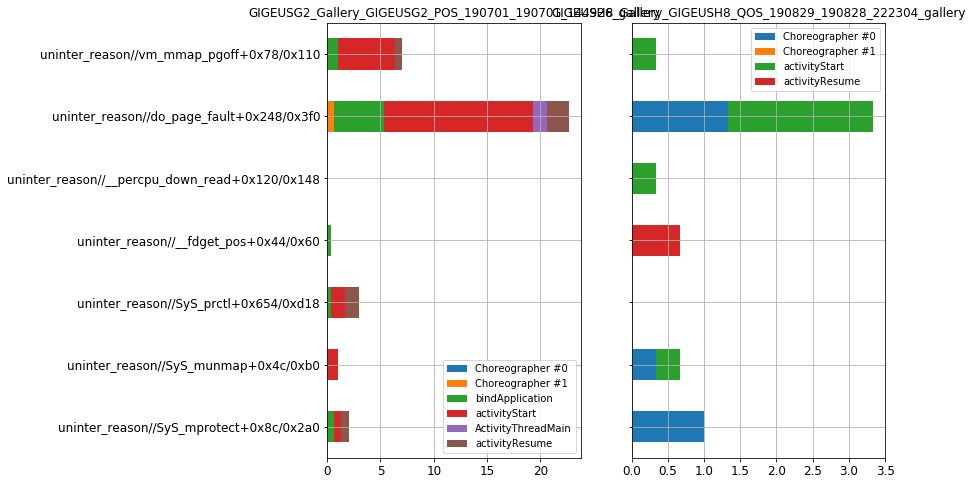

In [28]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

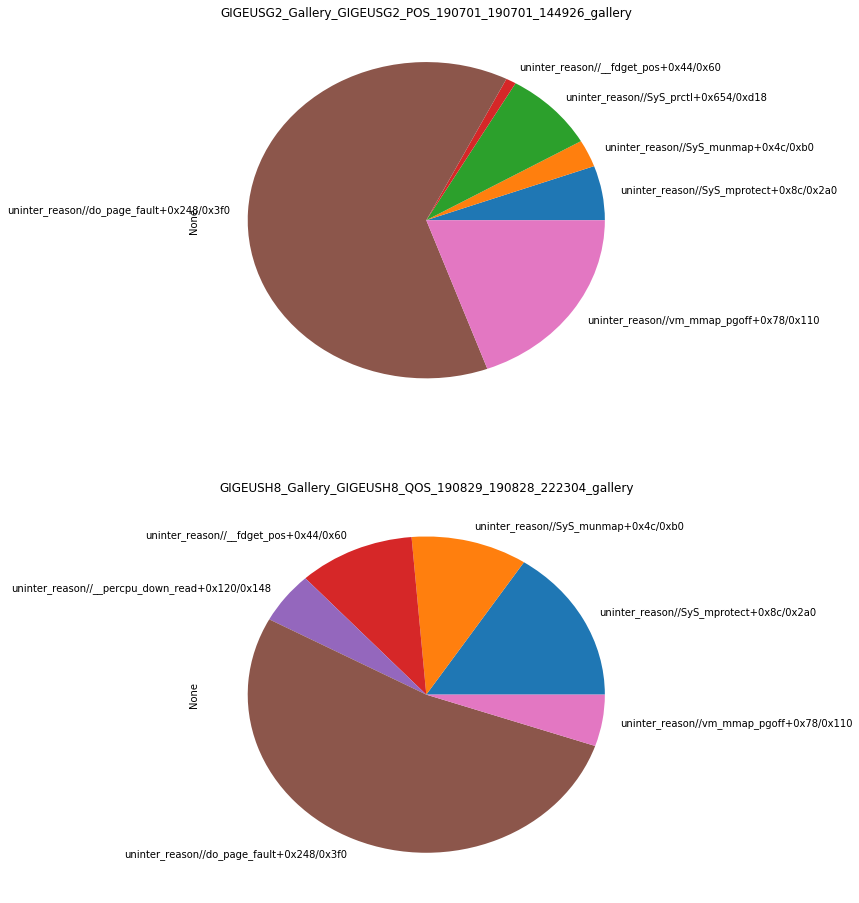

In [29]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [28]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [31]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... core0                 0   
                                                   core1                 0   
                                                   core2                 0   
                                                   core3                 0   
                                                   core4                 7   
                                                   core5                 6   
                                                   core6                 0   
                                                   core7                 4   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... core0                 1   
                                                   core1                 1   
                                                   core2                 1   
                                                   core3                 1   
                                                   core4                12   
                                                   core5                10   
                                                   core6                 5   
                                                   core7                 2   

                                                          Choreographer #1  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... core0                 0   
                                                   core1                 0   
                                                   core2                 0   
                                                   core3                 0   
                                                   core4                 7   
                                                   core5                 0   
                                                   core6                 7   
                                                   core7                 6   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... core0                 3   
                                                   core1                 1   
                                                   core2                 0   
                                                   core3                 1   
                                                   core4                 2   
                                                   core5                 0   
                                                   core6                14   
                                                   core7                 7   

                                                          bindApplication  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... core0              1.0   
                                                   core1             19.0   
                                                   core2              7.0   
                                                   core3              2.0   
                                                   core4             18.0   
                                                   core5             10.0   
                                                   core6             11.0   
                                                   core7             51.0   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... core0              NaN   
                                                   core1              NaN   
                                                   core2              NaN   
                                                   core3              NaN   
                                                   core4              NaN   
                                                   core5              NaN   
                                                   core6              NaN   
                                                   core7              NaN   

                                                          activityStart  \
GIGEUSG2_Gallery_GI

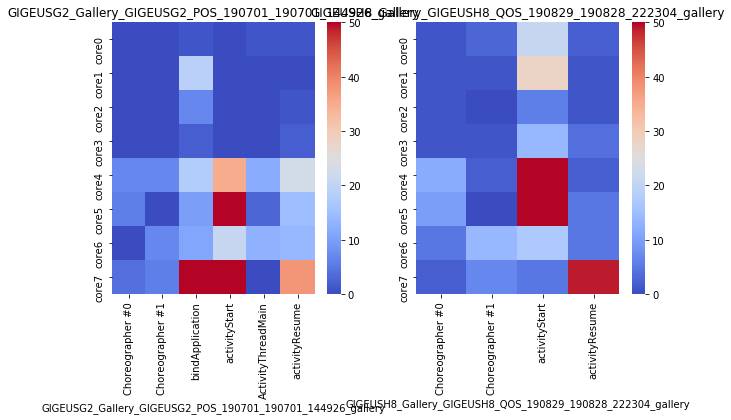

In [32]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [33]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,1,NaN
core1,NaN,0,0,4,0,0,0,NaN
core2,NaN,0,0,1,0,0,0,NaN
core3,NaN,0,0,0,0,0,1,NaN
core4,NaN,2,0,1,5,2,1,NaN
core5,NaN,3,0,0,14,0,0,NaN
core6,NaN,0,4,1,10,6,1,NaN
core7,NaN,1,0,36,70,0,23,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,0,0,0,NaN
core1,NaN,0,0,9,0,0,0,NaN
core2,NaN,0,0,3,0,0,1,NaN
core3,NaN,0,0,0,0,0,0,NaN
core4,NaN,5,1,7,20,8,2,NaN
core5,NaN,0,0,4,22,0,14,NaN
core6,NaN,0,2,9,8,3,12,NaN
core7,NaN,0,6,7,9,0,8,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,1,0,1,0,NaN
core1,NaN,0,0,6,0,0,0,NaN
core2,NaN,0,0,3,0,0,0,NaN
core3,NaN,0,0,2,0,0,1,NaN
core4,NaN,0,6,10,10,2,20,NaN
core5,NaN,3,0,6,33,3,1,NaN
core6,NaN,0,1,1,3,4,1,NaN
core7,NaN,3,0,8,16,0,7,NaN


In [34]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,2,NaN,2,NaN,2,NaN
core1,NaN,1,1,NaN,27,NaN,1,NaN
core2,NaN,0,0,NaN,0,NaN,1,NaN
core3,NaN,0,0,NaN,13,NaN,3,NaN
core4,NaN,5,2,NaN,14,NaN,0,NaN
core5,NaN,4,0,NaN,19,NaN,3,NaN
core6,NaN,2,0,NaN,6,NaN,1,NaN
core7,NaN,1,4,NaN,0,NaN,17,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,NaN,2,NaN,0,NaN
core1,NaN,0,0,NaN,0,NaN,0,NaN
core2,NaN,0,0,NaN,6,NaN,0,NaN
core3,NaN,0,0,NaN,1,NaN,0,NaN
core4,NaN,4,0,NaN,40,NaN,1,NaN
core5,NaN,3,0,NaN,6,NaN,1,NaN
core6,NaN,2,11,NaN,0,NaN,0,NaN
core7,NaN,1,0,NaN,0,NaN,18,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,1,NaN,17,NaN,0,NaN
core1,NaN,0,0,NaN,1,NaN,0,NaN
core2,NaN,1,0,NaN,0,NaN,0,NaN
core3,NaN,1,1,NaN,0,NaN,1,NaN
core4,NaN,3,0,NaN,13,NaN,1,NaN
core5,NaN,3,0,NaN,29,NaN,1,NaN
core6,NaN,1,3,NaN,11,NaN,4,NaN
core7,NaN,0,3,NaN,5,NaN,14,NaN


In [33]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [34]:
print(group1.title)
display(GetCoreStats(group1))

0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  I  R  I  I  I  V  I         6  331.352155
                   1    I  I  I  I  R  I  V  I         6  331.353734
                   2    I  R  I  I  I  I  V  R         6  331.354393
                   3    I  I  I  V  I  I  R  R         3  331.419727
bindApplication    0    I  I  I  V  I  I  I  I         3  331.421409
                   1    I  I  I  V  I  I  I  R         3  331.421773
                   2    R  I  R  I  I  V  I  I         5  331.422806
                   3    I  I  I  I  I  V  I  I         5  331.423297
                   4    R  R  I  I  I  I  I  V         7  331.429425
                   5    R  R  I  I  R  R  I  V         7  331.429820
                   6    R  R  R  I  R  I  I  V         7  331.435320
                   7    R  R  I  I  I  R  R  V         7  331.436094
                   8    I  R  R  I  I  I  R  V         7  331.436401
                   9    R  I  R  I  I  I  R  V         7  331.439969
                   10   I  V  I  I  R  I  R  I         1  331.448091
                   11   I  R  R  I  R  I  R  V         7  331.448223
                   12   I  I  I  I  R  R  I  V         7  331.451300
                   13   R  I  I  I  R  R  I  V         7  331.457286
                   14   R  R  I  I  I  I  I  V         7  331.457819
                   15   I  I  R  I  R  I  I  V         7  331.459617
                   16   I  I  I  I  I  I  I  V         7  331.461299
                   17   I  R  I  I  R  I  I  V         7  331.463194
                   18   I  I  I  I  R  I  I  V         7  331.463631
                   19   R  I  I  I  I  I  I  V         7  331.469880
                   20   R  R  I  R  R  I  I  V         7  331.470738
                   21   I  R  R  I  I  R  I  V         7  331.472566
                   22   R  I  I  R  I  I  I  V         7  331.473105
                   23   I  I  R  I  R  I  I  V         7  331.476076
                   24   I  I  R  I  R  I  R  V         7  331.477193
                   25   R  R  I  I  I  I  I  V         7  331.479269
                   26   I  I  I  I  I  I  R  V         7  331.479837
                   27   I  I  R  I  I  I  I  V         7  331.480557
                   28   I  I  I  I  R  I  I  V         7  331.480890
                   29   I  I  I  I  R  I  I  V         7  331.481278
                   30   I  I  I  I  R  I  I  V         7  331.482255
                   31   I  R  I  I  R  I  I  V         7  331.483431
                   32   R  I  R  I  I  I  I  V         7  331.483610
                   33   I  I  I  R  R  I  I  V         7  331.485213
                   34   R  I  I  R  R  I  I  V         7  331.485389
                   35   R  I  I  R  R  I  I  V         7  331.485709
                   36   R  I  I  R  R  R  I  V         7  331.486689
                   37   R  I  I  R  R  I  I  V         7  331.486973
                   38   R  I  I  R  R  I  I  V         7  331.487119
                   39   R  I  I  R  R  I  I  V         7  331.487393
                   40   R  I  R  I  R  I  I  V         7  331.487582
                   41   I  R  R  I  I  I  R  V         7  331.488067
                   42   I  R  R  I  I  I  R  V         7  331.488100
                   43   R  I  R  R  I  I  R  V         7  331.488405
                   44   R  R  I  R  I  R  I  V         7  331.489411
                   45   R  R  I  R  I  R  I  V         7  331.489940
                   46   R  I  I  I  I  R  V  R         6  331.492437
                   47   R  R  I  I  I  I  V  I         6  331.493535
                   48   R  R  I  I  I  R  V  I         6  331.494052
                   49   I  I  I  I  I  I  V  R         6  331.499015
                   50   I  I  I  I  I  I  I  V         7  331.499432
                   51   I  I  I  I  I  I  V  I         6  331.499486
                   52   I  I  R  I  R  R  V  I         6  331.501049
                   53 

In [35]:
print(group2.title)
display(GetCoreStats(group2))

0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0   I  I  R  I  V  I  I  I         4  340.122968
                   1   I  I  R  I  R  R  V  I         6  340.124183
                   2   R  R  I  I  R  R  V  I         6  340.139694
bindApplication    0   R  R  I  I  R  V  I  I         5  340.141316
                   1   R  R  I  I  R  V  I  R         5  340.141555
                   2   R  R  R  I  R  V  I  I         5  340.142782
                   3   I  R  R  I  R  V  I  I         5  340.143120
                   4   V  I  I  R  I  I  R  I         0  340.149280
                   5   I  R  I  R  V  I  R  I         4  340.150400
                   6   I  R  I  I  V  I  I  I         4  340.151588
                   7   I  R  I  I  V  I  I  I         4  340.152447
                   8   I  R  I  I  V  I  I  I         4  340.152694
                   9   R  I  I  I  V  I  I  I         4  340.153490
                   10  I  I  I  R  V  I  R  I         4  340.156072
                   11  I  I  I  I  V  I  R  I         4  340.158032
                   12  R  I  I  I  V  I  R  I         4  340.158694
                   13  I  I  I  I  V  I  R  I         4  340.162191
                   14  I  I  I  I  V  I  R  I         4  340.162365
                   15  I  I  I  I  V  I  R  I         4  340.163082
                   16  I  I  I  I  V  I  I  I         4  340.163619
                   17  I  I  I  I  V  I  R  I         4  340.167201
                   18  I  I  R  I  R  I  V  I         6  340.167382
                   19  I  I  I  R  R  I  V  I         6  340.168101
                   20  I  I  I  I  R  I  V  I         6  340.168484
                   21  R  I  I  I  R  I  V  I         6  340.168519
                   22  I  I  I  I  R  I  V  I         6  340.172449
                   23  R  R  I  R  R  I  V  I         6  340.182583
                   24  R  R  I  I  R  I  V  R         6  340.187064
                   25  R  R  I  I  R  I  V  I         6  340.187672
                   26  I  I  R  I  I  I  V  R         6  340.190805
                   27  I  R  R  I  I  I  V  R         6  340.192646
                   28  I  I  I  I  R  V  I  R         5  340.201203
                   29  I  I  I  I  R  R  V  R         6  340.201702
                   30  I  R  I  I  I  V  R  R         5  340.212633
                   31  I  R  I  R  R  V  R  R         5  340.213314
                   32  I  I  I  I  V  I  I  R         4  340.221819
                   33  I  R  I  I  R  V  I  R         5  340.222181
                   34  R  I  I  I  R  V  R  R         5  340.228187
                   35  I  R  I  I  R  V  R  I         5  340.235977
                   36  I  I  I  R  R  R  V  R         6  340.244766
                   37  R  I  R  R  V  R  R  I         4  340.248486
activityStart      0   R  R  I  I  R  R  V  I         6  340.249845
                   1   V  R  I  I  R  R  I  R         0  340.251933
                   2   R  R  I  I  V  R  I  R         4  340.252135
                   3   R  I  I  I  V  R  R  R         4  340.253476
                   4   R  I  R  I  V  I  R  R         4  340.253840
                   5   R  I  I  I  V  R  R  I         4  340.254368
                   6   R  I  I  I  V  R  R  R         4  340.254414
                   7   R  I  I  I  V  R  I  R         4  340.254465
                   8   R  I  I  I  R  R  V  R         6  340.254499
                   9   I  R  I  I  V  R  R  I         4  340.266093
                   10  I  I  I  R  V  R  R  R         4  340.266302
                   11  I  I  I  R  V  I  R  R         4  340.266333
                   12  I  I  I  R  V  I  R  R         4  340.266346
                   13  R  I  I  R  V  R  R  R         4  340.266458
                   14  R  R  V  I  I  R  R  R         2  340.266902
                   15  R  R  R  I  R  I  R  V         7  340.267082
                   16  I  R  I  I  V  R  R  I         4  340.269109
           

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [36]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


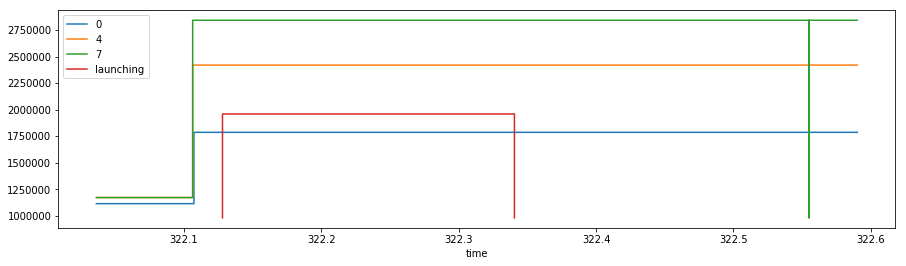

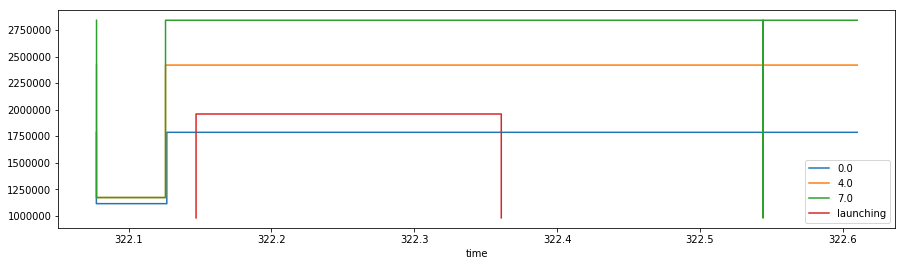

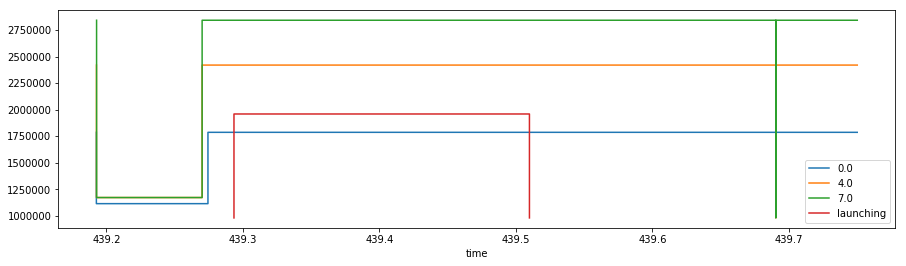

In [39]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']


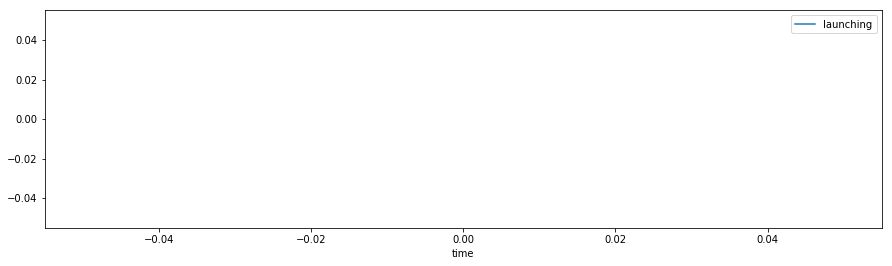

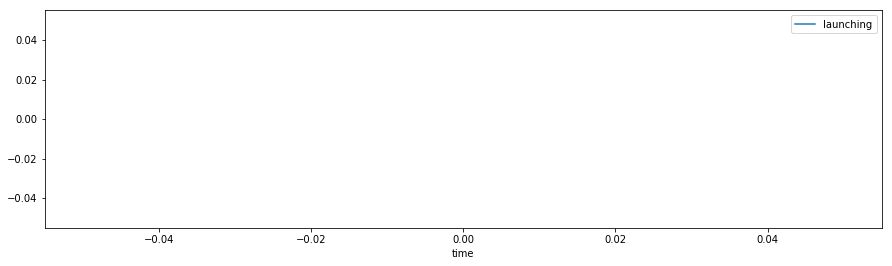

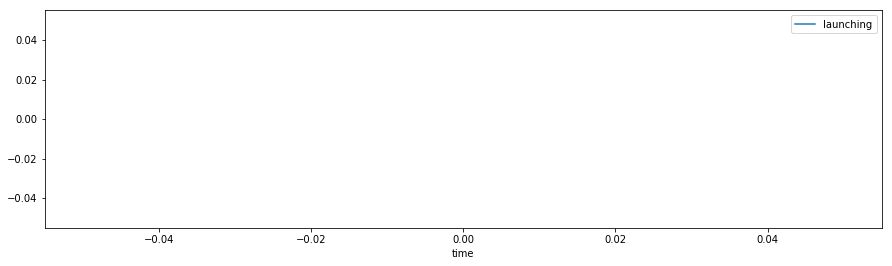

In [38]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [39]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting


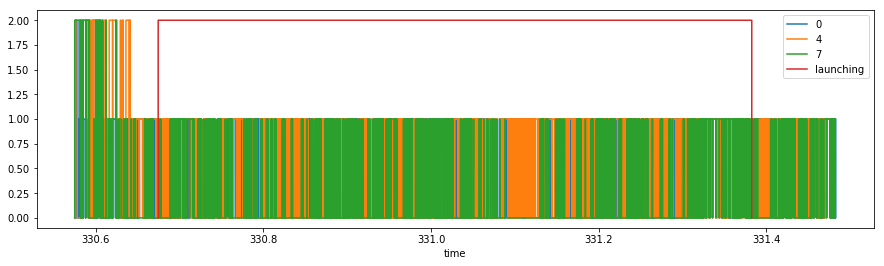

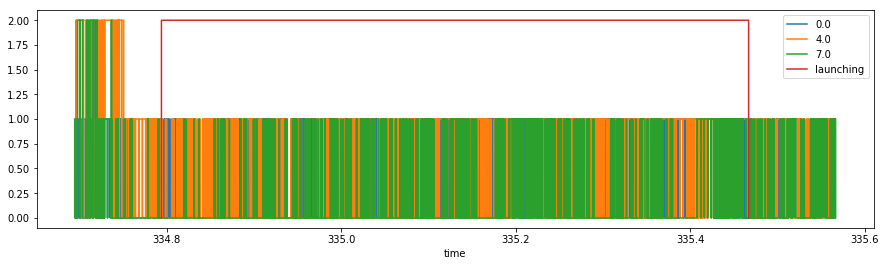

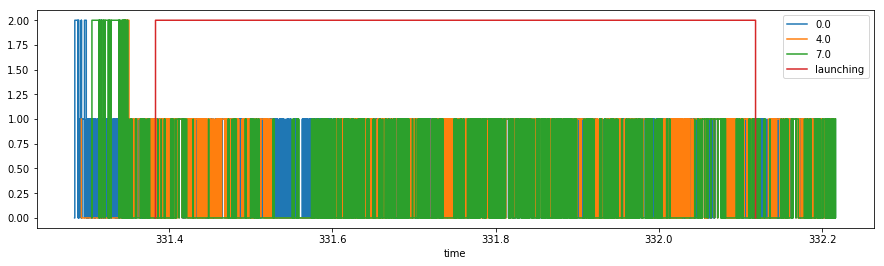

In [40]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting


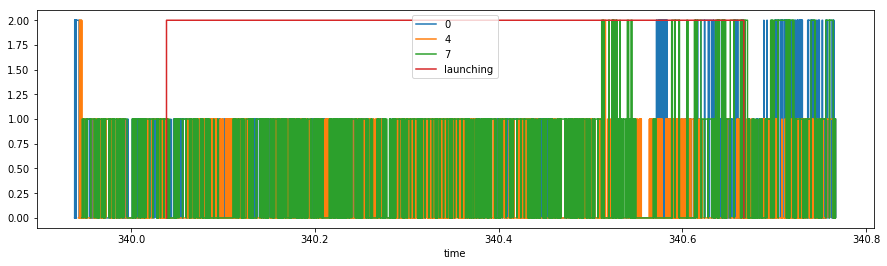

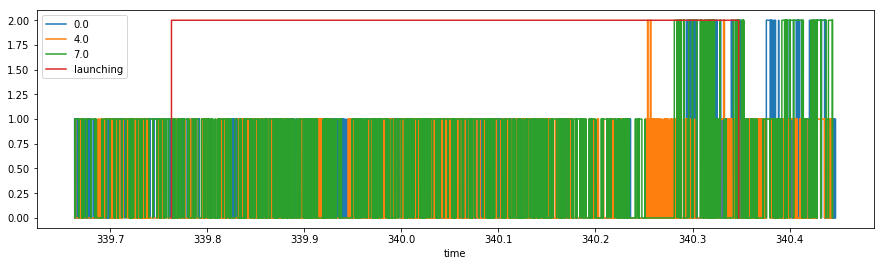

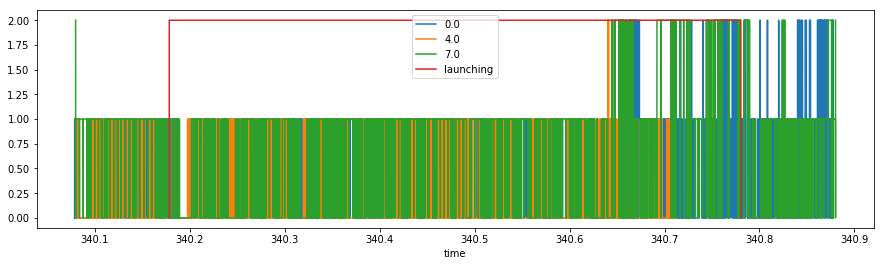

In [41]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [42]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [43]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting,lock_contention,0,7.93,0.000,9.933,3.558,21.770,11.203,0
0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting,lock_contention,0,45.96,2.961,13.559,8.964,20.266,5.894,0
DIFF,lock_contention,0,-38.03,-2.961,-3.626,-5.406,1.504,5.309,0


In [44]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [45]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting'

,blocking,context,duration,effection,owner,pid,time,type
12,int com.android.server.wm.MultiTaskingManager...,monitor contention with owner Binder:1234_16 (...,36.420,O,Binder:1234_16 (3049) at void com.android.serv...,1264,330.679676,B
13,com.android.server.policy.WindowManagerPolicy...,monitor contention with owner Binder:1234_10 (...,31.816,O,Binder:1234_10 (3039) at void com.android.serv...,1265,330.684393,B
15,boolean com.android.server.am.BaseRestriction...,monitor contention with owner FreecessHandler ...,16.099,O,FreecessHandler (2501) at void com.android.ser...,3049,330.689824,B
16,void com.android.server.am.freecess.FreecessC...,monitor contention with owner FreecessHandler ...,15.684,O,FreecessHandler (2501) at void com.android.ser...,3039,330.690505,B
82,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:1234_10 (...,13.648,O,Binder:1234_10 (3039) at void com.android.serv...,1264,331.048551,B
45,java.util.List com.android.server.am.Activity...,monitor contention with owner android.display ...,12.076,O,android.display (1264) at void com.android.ser...,1486,330.738215,B
20,android.app.ContentProviderHolder com.android...,monitor contention with owner Binder:1234_16 (...,8.758,O,Binder:1234_16 (3049) at android.app.ContentPr...,3084,330.708546,B
109,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1234_4 (1...,6.732,O,Binder:1234_4 (1438) at void com.android.serve...,3039,331.225675,B
23,void com.android.server.am.ProcessRecord.onSt...,monitor contention with owner Binder:1234_16 (...,5.811,O,Binder:1234_16 (3049) at android.app.ContentPr...,1264,330.716451,B
22,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner Binder:1234_10 (...,5.502,O,Binder:1234_10 (3039) at void com.android.serv...,3049,330.710784,B


In [46]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting'

,blocking,context,duration,effection,owner,pid,time,type
11,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:4970_E (6...,25.920,O,Binder:4970_E (6786) at void com.android.serve...,4987,340.042468,B
13,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:4970_E (6...,25.442,O,Binder:4970_E (6786) at void com.android.serve...,5027,340.043342,B
2,android.content.res.CompatibilityInfo com.and...,monitor contention with owner Binder:4970_2 (4...,15.708,O,Binder:4970_2 (4987) at int com.android.server...,6786,340.023038,B
15,com.android.server.wm.WindowProcessController...,monitor contention with owner Binder:4970_C (5...,15.628,O,Binder:4970_C (5617) at void com.android.serve...,6786,340.047823,B
16,com.android.server.policy.WindowManagerPolicy...,monitor contention with owner Binder:4970_C (5...,14.775,O,Binder:4970_C (5617) at void com.android.serve...,5029,340.048761,B
3,java.util.ArrayList com.android.server.wm.Win...,monitor contention with owner Binder:4970_2 (4...,9.651,O,Binder:4970_2 (4987) at int com.android.server...,6215,340.029190,B
94,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:4970_C (5...,8.688,O,Binder:4970_C (5617) at void com.android.serve...,5027,340.366837,B
133,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (50...,8.510,O,android.anim (5029) at void com.android.server...,5617,340.664046,B
5,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:4970_2 (4...,7.642,O,Binder:4970_2 (4987) at int com.android.server...,5027,340.031861,B
4,void com.android.server.wm.InputMonitor$1.run...,monitor contention with owner Binder:4970_2 (4...,7.322,O,Binder:4970_2 (4987) at int com.android.server...,5029,340.031656,B


In [47]:
display(group1.title)
display(df1['duration'].sum())

u'0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting'

247.0130000002655

In [48]:
display(group2.title)
display(df2['duration'].sum())

u'0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting'

224.90299999998342

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [49]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'0EBF5_0EBF5TC3_QOS_200304_200304_105505_setting'

,owner
"FreecessHandler (2501) at void com.android.server.am.freecess.FreecessController.triggerOLAF(java.lang.String, int)(FreecessController.java:1559)",8
android.anim (1265) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),7
"Binder:1234_10 (3039) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2302)",5
android.anim (1265) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:145),4
android.anim (1265) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:136),4
"Binder:1234_4 (1438) at android.content.pm.PackageInfo com.android.server.pm.PackageManagerService.getPackageInfoInternal(java.lang.String, long, int, int, int)(PackageManagerService.java:5265)",4
"android.ui (1262) at java.util.List com.android.server.wm.ActivityTaskManagerService.getFilteredTasks(int, int, int)(ActivityTaskManagerService.java:3400)",3
Binder:1234_10 (3039) at android.content.pm.UserInfo com.android.server.pm.UserManagerService.getUserInfo(int)(UserManagerService.java:1261),3
"Binder:1234_10 (3039) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:556)",3
"android.display (1264) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:556)",3


In [50]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'0EBF5_0FBF5TA2_QOS_200117_200117_181431_setting'

,owner
"FreecessHandler (6215) at void com.android.server.am.freecess.FreecessController.triggerOLAF(java.lang.String, int)(FreecessController.java:1522)",10
android.display (5027) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:5424),6
android.anim (5029) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),5
android.anim (5029) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),4
"Binder:4970_2 (4987) at int com.android.server.wm.ActivityStarter.startActivityMayWait(android.app.IApplicationThread, int, java.lang.String, int, int, android.content.Intent, java.lang.String, android.service.voice.IVoiceInteractionSession, com.android.internal.app.IVoiceInteractor, android.os.IBinder, java.lang.String, int, int, android.app.ProfilerInfo, android.app.WaitResult, android.content.res.Configuration, com.android.server.wm.SafeActivityOptions, boolean, int, com.android.server.wm.TaskRecord, java.lang.String, boolean, com.android.server.am.PendingIntentRecord, boolean)(ActivityStarter.java:1698)",4
"Binder:4970_E (6786) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",3
"Binder:4970_C (5617) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",3
android.anim (5029) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:132),3
"android.anim (5029) at int com.android.server.wm.WindowManagerService.addWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.view.InputChannel, android.view.InsetsState)(WindowManagerService.java:1388)",3
android.anim (5029) at void com.android.server.wm.WindowAnimator.lambda$new$1$WindowAnimator(long)(WindowAnimator.java:96),3


Text(0,0.5,'weight')

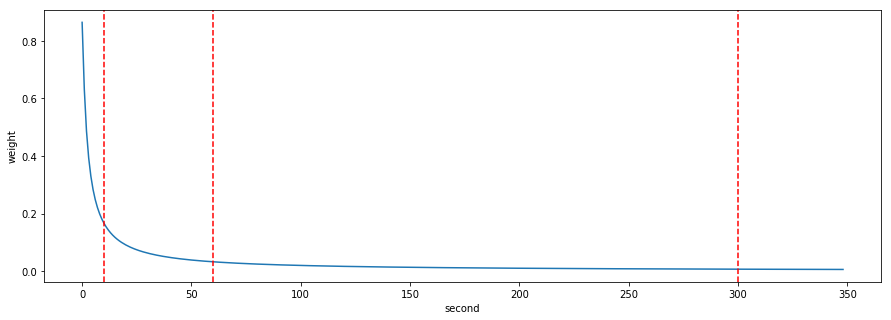

In [51]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')